In [103]:
import sys
import numpy as np
import random
import pickle
import os
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import models

sys.path.append("../../../FedLab/")

from fedlab.utils.dataset import functional as dataF
from fedlab.utils import SerializationTool

In [46]:
from fedlab.utils.dataset import CIFAR100Partitioner

In [88]:
params1 = SerializationTool.serialize_model(model)
params2 = SerializationTool.serialize_model(model)
params3 = params1.data
params4 = params1

print(params1)
print(params2)
print(params3)


tensor([-0.0535,  0.0145,  0.0168,  ..., -0.0213,  0.0006,  0.0269])
tensor([-0.0535,  0.0145,  0.0168,  ..., -0.0213,  0.0006,  0.0269])
tensor([-0.0535,  0.0145,  0.0168,  ..., -0.0213,  0.0006,  0.0269])


In [98]:
params1 is params2, params1 is params3, params1 is params4, params1.data is params3

(False, False, True, False)

In [97]:
print(type(params1), params1.requires_grad)
print(type(params2), params2.requires_grad)
print(type(params3), params3.requires_grad)
print(type(params4), params4.requires_grad)

<class 'torch.Tensor'> False
<class 'torch.Tensor'> False
<class 'torch.Tensor'> False
<class 'torch.Tensor'> False


In [118]:
def str2list(str):
    lis = str[1:-1].split(',')
    for i, ele in enumerate(lis):
        lis[i] = float(ele)
    return lis

def result_file_parser(file_name):
    res = dict()
    with open(file_name) as f:
        for line in f.readlines():
            line = line.strip()
            if line[0]=='{':
                line = line.replace("\'", "\"")
                res['setting'] = json.loads(line)
            else:
                line = line.split(':')
                key_name, value_str = line[0], line[1]
                values = str2list(value_str)
                res[key_name] = values
    return res

In [157]:
# res_files = [file for file in os.listdir("./Output/") if file[-3:]=='txt']
res_files = ['iid_Cifar10Net_cifar10.txt']
all_res = dict()
for fn in res_files:
    all_res[fn] = result_file_parser(os.path.join('./Output', fn))

round_num = len(all_res[res_files[0]]['all_mdl_test_acc'])
round_col = list(range(round_num))
content = {key:all_res[res_files[0]][key] for key in all_res[res_files[0]] if key!='setting'}
content['Round'] = round_col

res_df = pd.DataFrame(content)
res_df['Round'] = res_df['Round'].astype(int)
# res_df = res_df.set_index('Round')
col_names = list(res_df.columns)

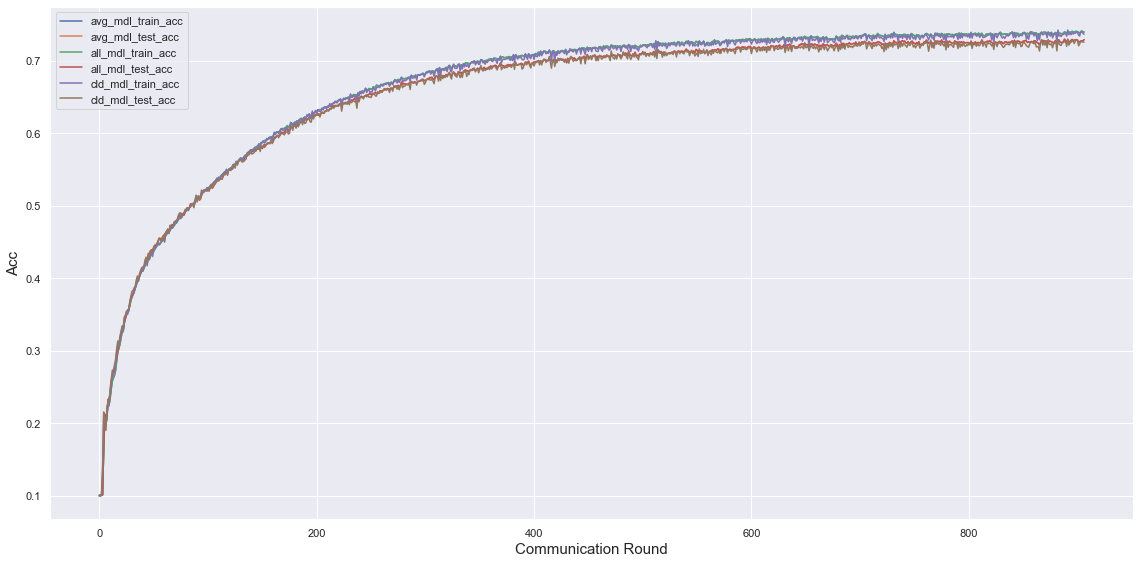

In [158]:
colors = ["#FF0B04", "#4374B3"]# Set your custom color palette
xy_fz = 15
title_fz = 20

sns.set_palette(sns.color_palette(colors))
sns.set_theme(style="ticks")
sns.set_style("darkgrid")
fig = plt.figure(figsize=(16, 8))  # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# plt.figure(figsize=(16, 8))
# plt.ylim([0, 1])

res_df.plot(x='Round', y=[key for key in col_names if key[-3:]=='acc'], grid=True, ax=ax)
plt.xlabel('Communication Round',fontsize=xy_fz)
plt.ylabel('Acc',fontsize=xy_fz)
# plt.xticks(list(range(round_num)))
plt.tight_layout()
# plt.savefig("./imgs/cifar10-feddyn-acc.png",dpi=400)

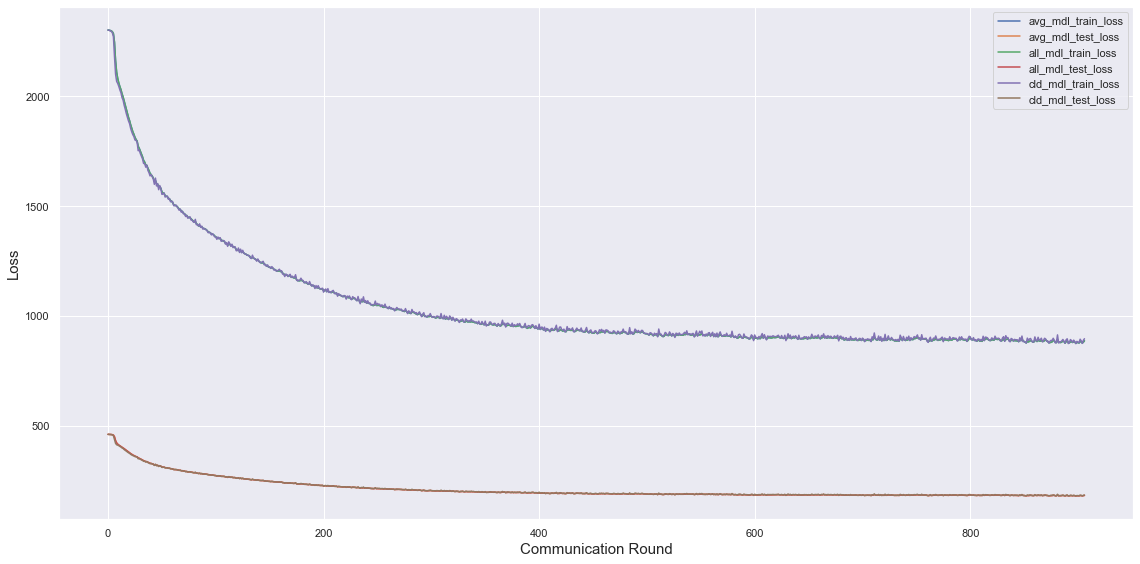

In [159]:
colors = ["#FF0B04", "#4374B3"]# Set your custom color palette
xy_fz = 15
title_fz = 20

sns.set_palette(sns.color_palette(colors))
sns.set_theme(style="ticks")
sns.set_style("darkgrid")
fig = plt.figure(figsize=(16, 8))  # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# plt.figure(figsize=(16, 8))
# plt.ylim([0, 1])

res_df.plot(x='Round', y=[key for key in col_names if key[-4:]=='loss'], grid=True, ax=ax)
plt.xlabel('Communication Round',fontsize=xy_fz)
plt.ylabel('Loss',fontsize=xy_fz)
# plt.xticks(list(range(round_num)))
plt.tight_layout()
# plt.savefig("./imgs/cifar10-feddyn-acc.png",dpi=400)

In [160]:
def evaluate(model, criterion, test_loader):
    model.eval()

    loss_ = AverageMeter()
    acc_ = AverageMeter()

    with torch.no_grad():
        for inputs, labels in test_loader:
            batch_size = len(labels)
            inputs = inputs
            labels = labels

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            acc1 = accuracy(outputs, labels, topk=(1,))

            loss_.update(loss.item(), batch_size)
            acc_.update(acc1[0].item(), batch_size)

    return loss_.avg, acc_.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k, in range of [0, 1]"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(1.0 / batch_size))
    return res

In [163]:
targets = torch.tensor([0,1,2,3,3])
outputs = torch.tensor([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,1,0],
                        [0,0,0,1],
                        [0,0,0,1]])
print(accuracy(outputs, targets)[0].item())

1.0


In [164]:
model = getattr(models, 'Cifar10Net')('Cifar10Net')